In [1]:
import os

os.chdir("../../")

import pandas as pd
import neuralprophet as nprophet
from matplotlib import pyplot as plt
import seaborn as sns
from src.data_handling import ingestion
import requests

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Make NeuralProphet deterministic
nprophet.set_random_seed(0)

#### Idea

Building a model that predicts the daily temperature over the next year based on the actual
temperatures over the last weeks and a professional forecast for the next days. Model will be mostly
informed by the learned seasonality **but will still include actual forecasts and current weather.**

## Seasonal autoregressive temperature model

In [2]:
temperatures = ingestion.read_temperatures()
temperatures.index.name = "ds"

temperatures = temperatures.rename("y").to_frame().reset_index()

# Split data into train and test
train = temperatures[temperatures["ds"] < "2019-01-01"]
test = temperatures[temperatures["ds"] >= "2019-01-01"]

# Create model
model = nprophet.NeuralProphet(
    n_forecasts=365,
    n_lags=45,
)

In [3]:
model.fit(train, freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 94
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (222) is too small than the required number for the learning rate finder (254). The results might not be optimal.


Finding best initial lr:   0%|          | 0/254 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,31.969990,39.995228,0.367955,0.0,0
1,21.184475,26.006393,0.183121,0.0,1
2,16.246809,19.969929,0.111937,0.0,2
3,11.033679,13.665928,0.052893,0.0,3
4,7.122589,8.894566,0.022073,0.0,4
...,...,...,...,...,...
89,2.728693,3.409198,0.003307,0.0,89
90,2.727196,3.406686,0.003302,0.0,90
91,2.725429,3.404498,0.003298,0.0,91
92,2.723744,3.402927,0.003295,0.0,92


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 222it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Text(0.5, 1.0, 'Prediction for a whole year')

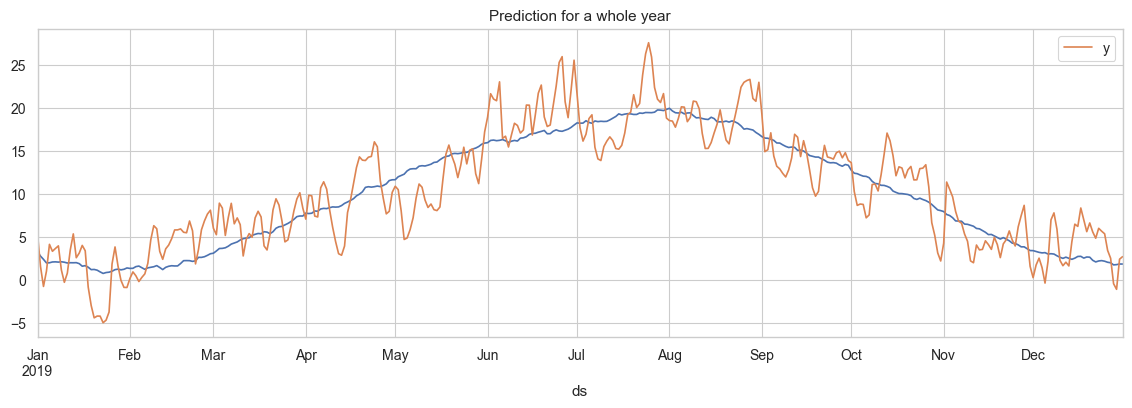

In [4]:
# Predict the temperature for a full year
future = model.make_future_dataframe(train, periods=365, n_historic_predictions=0)
prediction = model.predict(future)
latest_prediction = model.get_latest_forecast(prediction).set_index("ds")
actual = test.set_index("ds").loc["2019"]

# Plot the forecast
fig, ax = plt.subplots(figsize=(14, 4))

latest_prediction["origin-0"].plot(ax=ax, label="Prediction")
actual.plot(ax=ax, label="Actual")
ax.set_title("Prediction for a whole year")

## Current temperatures and forecast

In [5]:
# 5 evenly spaced cities in Germany with their coordinates
cities = [
    (52.520008, 13.404954), # Berlin
    (51.339695, 12.373075), # Dresden
    (50.937531, 6.960279), # Cologne
    (48.135125, 11.581981), # Munich
    (53.551086, 9.993682), # Hamburg
]

In [15]:
# "https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41&hourly=temperature_2m&past_days=31&forecast_days=16"
# make GET request to the API for each city

endpoint = "https://api.open-meteo.com/v1/forecast"

# Get temperature data for all cities (each city is one column in the resulting dataframe)
hourly_temperatures = pd.DataFrame()

for city in cities:
    params = {
        "latitude": city[0],
        "longitude": city[1],
        "hourly": "temperature_2m",
        "models": "ecmwf_ifs04",
        "past_days": 35,
        "forecast_days": 10,
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    
    temps = pd.Series(data["hourly"]["temperature_2m"], index=data["hourly"]["time"])
    hourly_temperatures[city] = temps

hourly_temperatures = hourly_temperatures.mean(axis="columns")

# Make index a datetime object
hourly_temperatures.index = pd.to_datetime(hourly_temperatures.index)

# Group hourly temperatures by day
daily_temperatures = hourly_temperatures.groupby(pd.Grouper(freq="D")).mean()

### Make long-term model predictions based on actual temperatures and professional short-term forecast

In [16]:
actual_temp_df = daily_temperatures.rename("y").to_frame()
actual_temp_df.index.name = "ds"
actual_temp_df = actual_temp_df.reset_index()

In [17]:
future = model.make_future_dataframe(actual_temp_df, n_historic_predictions=30)
prediction = model.predict(future)
latest_prediction = model.get_latest_forecast(prediction).set_index("ds")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 30 historic forecasts, reduced to 0.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 222it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


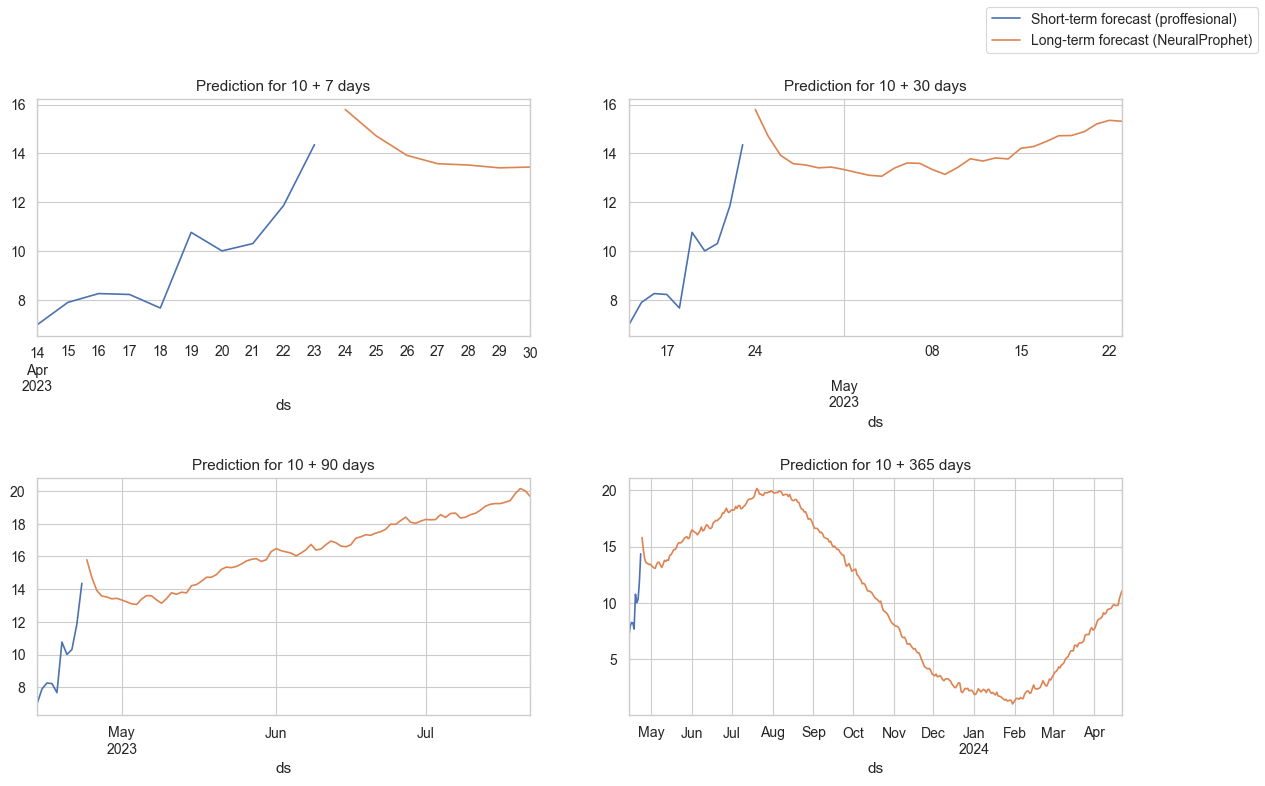

In [19]:
# Show 4 subplots with different time horizons and the temperature forecast (1 week, 1 month, 3 months, 1 year)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# More vertical space
fig.subplots_adjust(hspace=0.6)

for i, ax in enumerate(axes.flatten()):
    additional_horizon = [7, 30, 90, 365][i]

    daily_temperatures.iloc[-10:].plot(ax=ax, label="Short-term forecast (proffesional)")
    latest_prediction["origin-0"].iloc[:additional_horizon].plot(ax=ax, label="Long-term forecast (NeuralProphet)")
    ax.set_title(f"Prediction for 10 + {additional_horizon} days")
    
# Shared legend
fig.legend(["Short-term forecast (proffesional)", "Long-term forecast (NeuralProphet)"], loc="upper right", ncol=1)